<a href="https://colab.research.google.com/github/megha-puthukudi/main-project/blob/VGG19-SPOT/vecicle_spot_position_VGG19_epoch_100_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Found 1042 images belonging to 3 classes.
Found 225 images belonging to 3 classes.
Found 215 images belonging to 3 classes.
80134624/80134624 [==============================] - 1s 0us/step
Epoch 1/100
32/32 [==============================] - 288s 9s/step - loss: 1.7507 - accuracy: 0.3733 - val_loss: 1.1116 - val_accuracy: 0.4509
Epoch 2/100
32/32 [==============================] - 19s 583ms/step - loss: 1.0481 - accuracy: 0.4168 - val_loss: 1.0557 - val_accuracy: 0.5223
Epoch 3/100
32/32 [==============================] - 19s 583ms/step - loss: 0.9940 - accuracy: 0.5139 - val_loss: 0.9590 - val_accuracy: 0.5625
Epoch 4/100
32/32 [==============================] - 19s 585ms/step - loss: 0.9389 - accuracy: 0.5663 - val_loss: 0.8563 - val_accuracy: 0.6473
Epoch 5/100
32/32 [==============================] - 19s 577ms/step - loss: 0.8769 - accuracy: 0.6119 - val_loss: 0.7364 - val_accuracy: 0.7188
Epoch 6/100
32/32 [==============================] - 19s 585ms/step - loss: 0.7870 - accuracy

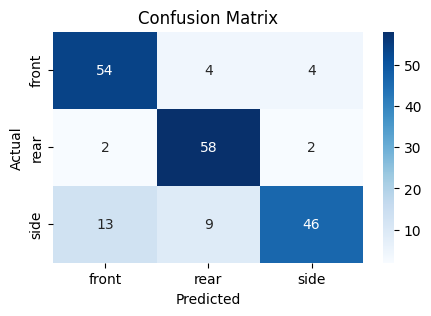

Test loss: 1.5960
Test accuracy: 82.29
Train loss: 0.0545
Train accuracy: 97.27
Recall: 0.83
Precision: 0.83
F1-score: 0.82


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns  # Added seaborn for visualization

# Define your data directories
train_dir = '/content/drive/MyDrive/dataset for spot/train'
val_dir = '/content/drive/MyDrive/dataset for spot/validation'
test_dir = '/content/drive/MyDrive/dataset for spot/test'

# Define image size and batch size
img_size = (224, 224)
batch_size = 32  # Increase batch size for faster convergence

# Create data generators with more aggressive data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the pre-trained VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add a global average pooling layer
x = GlobalAveragePooling2D()(base_model.output)

# Add dropout for regularization
x = Dropout(0.5)(x)

# Add a dense output layer with softmax activation
predictions = Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model except the last few
for layer in base_model.layers[:-5]:
    layer.trainable = False

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=100,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size,
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // batch_size)
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.n // batch_size)

# Calculate recall
y_true = []
y_pred = []
for i in range(test_generator.n // batch_size):
    batch_x, batch_y = next(test_generator)
    y_true.extend(np.argmax(batch_y, axis=1))
    y_pred.extend(np.argmax(model.predict(batch_x), axis=1))

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['front', 'rear', 'side'], yticklabels=['front', 'rear', 'side'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate other metrics
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
# Display metrics
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy * 100:.2f}')
print(f'Train loss: {train_loss:.4f}')
print(f'Train accuracy: {train_accuracy * 100:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1-score: {f1:.2f}')

# Save the trained model
model.save('/content/drive/MyDrive/colabtest/vecicle_spot_position_VGG19_epoch_100_dataset.h5')
